In [1]:
import os
import time
import random
import warnings
import typing as tp
import pathlib
from contextlib import contextmanager

import cv2
import librosa

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

In [2]:
import python_speech_features as psf
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
data_path = pathlib.Path("../data")

In [4]:
train = pd.read_csv(data_path/'Train.csv')
train.head()

,fn,label
0,audio_files/IV38R7F.wav,akawuka
1,audio_files/KM4SKWT.wav,banana
2,audio_files/F5POSU9.wav,obulwadde
3,audio_files/MMVDXG2.wav,nnyaanya
4,audio_files/9TVM96F.wav,pampu


In [5]:
train_extra = pd.read_csv(data_path/'train_add.csv')
train_extra.head(3)

,fn,label
0,audio_files_full/3d43af6faf2244c288154dc4ff6a7...,obuwuka
1,audio_files_full/3d43af6faf2244c288154dc4ff6a7...,obuwuka
2,audio_files_full/744b1a437234489fae9512694d221...,obuwuka


In [6]:
train_extra_2 = pd.read_csv(data_path/'train_add_20201029.csv')
train_extra_2.head(3)

,fn,label
0,audio_files_full_20201029/2497942026ef4d7e97d4...,obuwuka
1,audio_files_full_20201029/d027264654b94950aeb2...,ejjobyo
2,audio_files_full_20201029/d027264654b94950aeb2...,ejjobyo


In [7]:
label2code = {word: idx for idx, word in enumerate(train.label.unique().tolist())}
code2label = {v:k for k,v in label2code.items()}

In [8]:
audios_path = data_path / "all_audio_resampled"

In [9]:
def get_image_path(audio_path):
    file_name = audio_path.split("/")[-1].split(".")[0]
    ip = str(audios_path.resolve() / f"{file_name}.wav")
    return ip

train["image_fn"] = train.fn.apply(get_image_path)
train_extra["image_fn"] = train_extra.fn.apply(get_image_path)
train_extra_2["image_fn"] = train_extra_2.fn.apply(get_image_path)

In [10]:
train_df = pd.concat([train, train_extra], axis=0).reset_index(drop=True)

In [11]:
### build validation that includes all classes:


vcs = train_df.label.value_counts()

## possible schema:
# 25+ - take 3
# 12-25 - take 2
# 12- - take 1

def num_for_val(num_examples):
    if num_examples >= 25:
        return 3
    if num_examples >= 12:
        return 2
    return 1

train_df["num_examples"] = train_df.label.map(vcs.to_dict())
train_df["num_for_val"] = train_df.num_examples.apply(num_for_val)

random.seed(12)
train_df_new = pd.DataFrame()
for label in train_df.label.unique():
    tmp = train_df.loc[train_df.label == label].copy()
    tmp["dummy"] = tmp.label.apply(lambda _: random.random())
    tmp.sort_values(by="dummy", inplace=True)
    tmp["rank"] = range(tmp.shape[0])
    train_df_new = pd.concat([train_df_new, tmp])

train_df_new.reset_index(drop=True, inplace=True)
train_df_new["val_subset"] = train_df_new.num_for_val > train_df_new["rank"]
train_df_new.drop("dummy", axis=1, inplace=True)

In [12]:
assert (
    set(train_df_new.loc[train_df_new.val_subset].label.unique()) == 
    set(train_df_new.loc[~train_df_new.val_subset].label.unique())
)

In [13]:
# from sklearn.model_selection import train_test_split

train_df, val_df = train_df_new.loc[~train_df_new.val_subset].copy(), train_df_new.loc[train_df_new.val_subset].copy()
print(train_df.shape)
print(val_df.shape)

(2500, 7)
(349, 7)


In [14]:
train_df = pd.concat([
    train_df.drop(["num_examples", "num_for_val", "rank", "val_subset"], axis=1),
    train_extra_2
]).reset_index(drop=True)

In [15]:
print(train_df.shape)
print(val_df.shape)

(4360, 3)
(349, 7)


In [16]:
## check no val leaking
assert train_df.merge(val_df, on=["image_fn"], how="inner").shape[0] == 0

In [17]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, trg=None):
        if trg is None:
            for t in self.transforms:
                image = t(image)
            return image
        else:
            for t in self.transforms:
                image, trg = t(image, trg)
            return image, trg


class UseWithProb:
    def __init__(self, transform, prob=.5):
        self.transform = transform
        self.prob = prob

    def __call__(self, image, trg=None):
        if trg is None:
            if random.random() < self.prob:
                image = self.transform(image)
            return image
        else:
            if random.random() < self.prob:
                image, trg = self.transform(image, trg)
            return image, trg


class OneOf:
    def __init__(self, transforms, p=None):
        self.transforms = transforms
        self.p = p

    def __call__(self, image, trg=None):
        transform = np.random.choice(self.transforms, p=self.p)
        if trg is None:
            image = transform(image)
            return image
        else:
            image, trg = transform(image, trg)
            return image, trg

In [18]:
SR = 22050

In [19]:
class PitchShift:
    def __init__(self, pitch_range, sr=SR):
        self.pr_low, self.pr_hi = pitch_range
        self.sr=sr
    
    def __call__(self, audio):
        shift = np.random.choice(np.linspace(self.pr_low, self.pr_hi, 100))
        return librosa.effects.pitch_shift(audio, self.sr, shift)


class TimeStretch:
    def __init__(self, stretch_param):
        self.stretch = stretch_param
    
    def __call__(self, audio):
        """
        if self.stretch is one number, use it as stretch param.
        if it's 2nums array, use it as limits for uniform distribution
        from which we sample stretch param
        """
        if type(self.stretch) in (int, float):
            return librosa.effects.time_stretch(audio, self.stretch)
        else:
            low, hi = self.stretch
            s = np.random.choice(np.linspace(low, hi, 100))
            return librosa.effects.time_stretch(audio, s)
        
class AddNoise:
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale
        
    def __call__(self, audio):
        noise = np.random.normal(loc=self.loc, scale=self.scale, size=audio.shape)
        return noise + audio

In [20]:
import IPython.display as ipd

idx = np.random.randint(train_df.shape[0])
print(idx)
print(train_df.iloc[idx].values)
p = train_df.iloc[idx]["image_fn"]

raw, _ = librosa.core.load(p, sr=SR)

3600
['audio_files_full_20201029/d027264654b94950aeb204f64d05d8d7_49386199acdf4c2ab6ade67216e8dc8e.wav'
 'ebikongoliro'
 '/home/letfoolsdie/zindi_nlp/data/all_audio_resampled/d027264654b94950aeb204f64d05d8d7_49386199acdf4c2ab6ade67216e8dc8e.wav']


In [21]:
ipd.Audio(raw, rate=SR)

In [22]:
aug_noise = AddNoise(0, 0.03)
aug_ts = TimeStretch((0.5, 2))
aug_pitch = PitchShift((-5, 5))

combo_aug = OneOf([
    aug_noise,
    aug_ts,
    aug_pitch
])

ipd.Audio(combo_aug(raw), rate=SR)

In [23]:
def audio2image(signal, sample_rate=SR, window_length=0.05, window_step=0.0045, NFFT=2205):

    # preemphasis
    signal = psf.sigproc.preemphasis(signal, coeff=0.95)

    # get specrogram
    # Get the frames
    frames = psf.sigproc.framesig(signal, 
                                  window_length*sample_rate, 
                                  window_step*sample_rate, 
                                  lambda x:np.ones((x,)))        # Window function 

    # magnitude Spectrogram
    spectrogram = np.rot90(psf.sigproc.magspec(frames, NFFT))

    # get rid of high frequencies
    spectrogram = spectrogram[512:,:]

    # normalize in [0, 1]
    spectrogram -= spectrogram.min(axis=None)
    spectrogram /= spectrogram.max(axis=None)        

    spectrogram = spectrogram[:591, :549]

    return spectrogram 


def build_spectrogram(raw_audio):

    # Use our function from earlier
    spectrogram = audio2image(raw_audio) # a 2D array

    # Pad to make sure it is 512 x 512
    h, w = spectrogram.shape
    spectrogram = np.pad(spectrogram, [(591-h, 0), (549-w, 0)])

    # Scale to (0, 255)
    spectrogram  -= spectrogram.min()
    spectrogram *= 255.0/spectrogram.max()

    # Make it uint8
    im_arr = np.array(spectrogram, np.uint8)

    # Make it rgb (hint - some fun tricks you can do here!)
    r = im_arr
    g = im_arr
    b = im_arr

    return np.stack([r, g, b], axis=-1)

In [24]:
%%time

## try read all audios and hold them in memory:
train_audios_dict = dict()
for p, _ in train_df[["image_fn", "label"]].values.tolist():
    tmp_a, _ = librosa.core.load(p, sr=SR)
    train_audios_dict[p] = tmp_a
    
val_audios_dict = dict()
for p, _ in val_df[["image_fn", "label"]].values.tolist():
    tmp_a, _ = librosa.core.load(p, sr=SR)
    val_audios_dict[p] = tmp_a
    

CPU times: user 695 ms, sys: 304 ms, total: 999 ms
Wall time: 1 s


In [25]:
import torchvision.transforms as tr
from PIL import Image

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def normalize(image, mean, std):
    image = (image / 255.0).astype(np.float32)
    image = (image - mean) / std
    return image

class SpectrogramDataset(data.Dataset):
    def __init__(
        self,
        file_list: tp.List[tp.List[str]],
        audios_dict,
        img_size=224,
        transform=None,
        normalize=True
    ):
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.transform = transform
        self.normalize = normalize
        self.audios_dict = audios_dict

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        fn, word = self.file_list[idx]
        #audio, _ = librosa.core.load(fn, sr=SR)
        audio = self.audios_dict[fn]

        if self.transform:
            audio = self.transform(audio)

        image = build_spectrogram(audio)
        image = cv2.resize(image, (self.img_size, self.img_size))
        
        if self.normalize:
            norm_image = normalize(np.array(image), mean=MEAN, std=STD)
        else:
            norm_image = image
        
        return np.moveaxis(norm_image, 2, 0), label2code[word]
    
    
class SpectrogramTestDataset(data.Dataset):
    def __init__(
        self,
        file_list: tp.List[tp.List[str]],
        img_size=224,
        transform=None
    ):
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.transform = transform
        self.normalize = normalize
#         self.audios_dict = audios_dict

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        fn, word = self.file_list[idx]
        audio, _ = librosa.core.load(fn, sr=SR)
#         audio = self.audios_dict[fn]

        if self.transform:
            audio = self.transform(audio)

        image = build_spectrogram(audio)
        image = cv2.resize(image, (self.img_size, self.img_size))
        
        if self.normalize:
            norm_image = normalize(np.array(image), mean=MEAN, std=STD)
        else:
            norm_image = image
        
        return np.moveaxis(norm_image, 2, 0)

In [26]:
import torchvision.transforms as tr


img_size = 224

aug_noise = AddNoise(0, 0.07)
aug_ts = TimeStretch((0.5, 2))
aug_pitch = PitchShift((-5, 5))

train_transforms = OneOf([
    aug_noise,
    aug_ts,
    aug_pitch
])


In [27]:
sdf_train = SpectrogramDataset(train_df[["image_fn", "label"]].values.tolist(), train_audios_dict,
                               transform=train_transforms, normalize=True)
sdf_val = SpectrogramDataset(val_df[["image_fn", "label"]].values.tolist(), val_audios_dict, img_size)

In [29]:
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, models, transforms

model_ft = models.resnet50(pretrained=True)
print(model_ft.fc.in_features)

n_classes = len(label2code)

model_ft.fc = nn.Sequential(
    nn.Linear(model_ft.fc.in_features, n_classes)
)

device = torch.device("cuda")

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(reduction="sum")

optimizer_ft = optim.Adam(model_ft.parameters(), lr=2e-4)

2048


In [31]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(optimizer_ft, 'min', patience=4, factor=0.5, verbose=True, min_lr=2e-5)

In [32]:
def train_epoch(log_interval, model, device, criterion, train_loader, optimizer, epoch):
#     print(epoch)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.type(torch.FloatTensor).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

            
def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.type(torch.FloatTensor).to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

    return test_loss, accuracy

In [33]:
train_loader = torch.utils.data.DataLoader(sdf_train, batch_size=64, shuffle=True,
                                           num_workers=4, drop_last=False, pin_memory=True) ## ADDED shuffle
val_loader = torch.utils.data.DataLoader(sdf_val, batch_size=32, drop_last=False, pin_memory=True)

In [34]:
test(model_ft, device, criterion, val_loader)


Test set: Average loss: 5.2923, Accuracy: 0/349 (0%)



(5.292257139539308, 0.0)

In [35]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)



t0 = time.time()
alphabet = "abcdefghijklmnopqrstuvwxyz"
tmp_folder_name = "resnet50_aug_exp"

best_loss = 1e5
best_acc = 0

max_patience = 20
patience = 0
os.mkdir(f"tmp/{tmp_folder_name}")

train_loss_hist = list()
val_loss_hist = list()
val_acc_hist = list()

save_each_epoch = False

set_seed(9)


for ep in range(50):
    train_loss = train_epoch(1e10, model_ft, device, criterion, train_loader, optimizer_ft, ep)
    cur_loss, cur_acc = test(model_ft, device, criterion, val_loader)
    
    train_loss_hist.append(train_loss)
    val_loss_hist.append(cur_loss)
    val_acc_hist.append(cur_acc)
    
    if save_each_epoch:
        torch.save(model_ft.state_dict(), f"tmp/{tmp_folder_name}/model_ep_{ep}.pth")

    if cur_loss < best_loss:
        torch.save(model_ft.state_dict(), f"tmp/{tmp_folder_name}/best_run.pth")
        best_loss = cur_loss
        best_acc = cur_acc
        patience = 0
    else:
        patience += 1
#         print("patience:", patience)
#         if patience > max_patience:
#             break

    lr_scheduler.step(cur_loss) ## removed lr scheduler for now
    print("Training so far {} minutes".format((time.time() - t0) / 60))
    print("="*20)

print("time spent training: {} minutes".format((time.time() - t0) / 60))

Train Epoch: 0 [0/4360 (0%)]	Loss: 342.523315

Test set: Average loss: 4.3727, Accuracy: 42/349 (12%)

Training so far 1.234120535850525 minutes
Train Epoch: 1 [0/4360 (0%)]	Loss: 253.998260

Test set: Average loss: 3.3529, Accuracy: 87/349 (25%)

Training so far 2.4755823850631713 minutes
Train Epoch: 2 [0/4360 (0%)]	Loss: 176.148193

Test set: Average loss: 2.9135, Accuracy: 112/349 (32%)

Training so far 3.730493410428365 minutes
Train Epoch: 3 [0/4360 (0%)]	Loss: 116.348457

Test set: Average loss: 2.3206, Accuracy: 156/349 (45%)

Training so far 4.969377589225769 minutes
Train Epoch: 4 [0/4360 (0%)]	Loss: 117.559639

Test set: Average loss: 2.3598, Accuracy: 154/349 (44%)

Training so far 6.184211901823679 minutes
Train Epoch: 5 [0/4360 (0%)]	Loss: 90.339401

Test set: Average loss: 1.8244, Accuracy: 201/349 (58%)

Training so far 7.3976314504941305 minutes
Train Epoch: 6 [0/4360 (0%)]	Loss: 64.734421

Test set: Average loss: 1.6505, Accuracy: 206/349 (59%)

Training so far 8.6237

Train Epoch: 48 [0/4360 (0%)]	Loss: 7.184763

Test set: Average loss: 0.9025, Accuracy: 290/349 (83%)

Training so far 59.86297037204107 minutes
Train Epoch: 49 [0/4360 (0%)]	Loss: 3.671824

Test set: Average loss: 0.9231, Accuracy: 289/349 (83%)

Training so far 61.09418869415919 minutes
time spent training: 61.094191145896914 minutes


In [37]:
torch.save(model_ft.state_dict(), f"tmp/{tmp_folder_name}/model_ep_{ep}.pth")


In [38]:
# torch.save(model_ft.state_dict(), f"resnet18_ep30.pth")
best_loss

0.8991776878990895

In [39]:
tmp_folder_name

'resnet50_aug_exp'

In [40]:
best_acc / 100

0.8280802292263609

In [41]:
import matplotlib.pyplot as plt

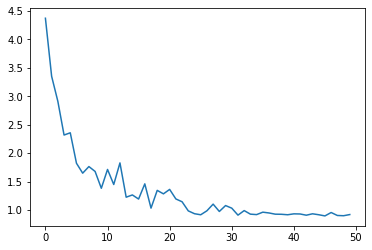

In [42]:
plt.plot(range(len(val_loss_hist)), val_loss_hist)

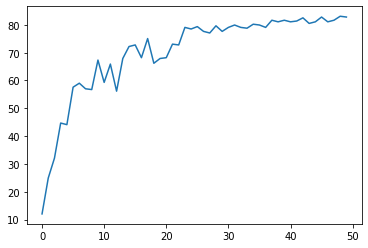

In [43]:
plt.plot(range(len(val_acc_hist)), val_acc_hist)

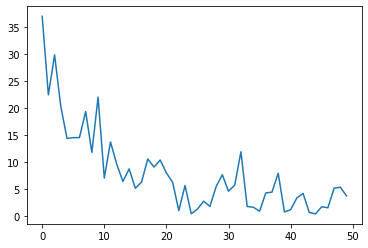

In [44]:
plt.plot(range(len(train_loss_hist)), train_loss_hist)

In [45]:
model_ft.load_state_dict(torch.load(f"tmp/{tmp_folder_name}/best_run.pth"))

<All keys matched successfully>

In [46]:
## try inference:
test_loader = torch.utils.data.DataLoader(sdf_val, batch_size=16)

In [47]:
%%time

sfm = nn.Softmax()
predictions = list()

for batch_idx, (inputs, _) in enumerate(test_loader):
    inputs = inputs.type(torch.FloatTensor).to(device)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        predictions.append(sfm(outputs)) ## ADD SOFTMAX

predictions = np.concatenate([t.cpu().numpy() for t in predictions])
preds = np.argmax(predictions, axis=1)

/home/letfoolsdie/virtual_envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


CPU times: user 9.49 s, sys: 11.4 ms, total: 9.5 s
Wall time: 8.59 s


In [48]:
val_df["preds"] = [code2label[c] for c in preds]

In [49]:
(val_df.label == val_df.preds).mean()

0.828080229226361

## Prepare submission:

In [50]:
sample_subm = pd.read_csv("Submission1.csv")
sample_subm.head(3)

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0.002769,0.002084,0.005227,0.002884,0.004507,0.003533,0.001687,0.001626,0.003026,...,0.001507,0.002586,0.000081,0.000787,0.001928,0.004070,0.000132,0.000324,0.003241,0.003494
1,audio_files/00P0NMV.wav,0.001113,0.006091,0.001480,0.005104,0.004039,0.001252,0.000326,0.009214,0.000750,...,0.002991,0.001708,0.001014,0.000887,0.218384,0.002322,0.026944,0.014598,0.005134,0.004125
2,audio_files/01QEEZI.wav,0.001245,0.003642,0.001077,0.005952,0.006379,0.003655,0.002700,0.002457,0.000995,...,0.007273,0.005435,0.000962,0.002200,0.001465,0.001184,0.000905,0.000909,0.000670,0.001558


In [51]:
sample_subm["image_fn"] = sample_subm.fn.apply(get_image_path)

In [52]:
sample_subm.head(3)

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu,image_fn
0,audio_files/00118N3.wav,0.002769,0.002084,0.005227,0.002884,0.004507,0.003533,0.001687,0.001626,0.003026,...,0.002586,0.000081,0.000787,0.001928,0.004070,0.000132,0.000324,0.003241,0.003494,/home/letfoolsdie/zindi_nlp/data/all_audio_res...
1,audio_files/00P0NMV.wav,0.001113,0.006091,0.001480,0.005104,0.004039,0.001252,0.000326,0.009214,0.000750,...,0.001708,0.001014,0.000887,0.218384,0.002322,0.026944,0.014598,0.005134,0.004125,/home/letfoolsdie/zindi_nlp/data/all_audio_res...
2,audio_files/01QEEZI.wav,0.001245,0.003642,0.001077,0.005952,0.006379,0.003655,0.002700,0.002457,0.000995,...,0.005435,0.000962,0.002200,0.001465,0.001184,0.000905,0.000909,0.000670,0.001558,/home/letfoolsdie/zindi_nlp/data/all_audio_res...


In [53]:
def get_predictions(model, test_loader):
    sfm = nn.Softmax()
    predictions = list()
    for batch_idx, inputs in enumerate(test_loader):
        inputs = inputs.type(torch.FloatTensor).to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            predictions.append(sfm(outputs)) ## ADD SOFTMAX
    predictions = np.concatenate([t.cpu().numpy() for t in predictions])
    return predictions

In [54]:
subm_dataset = SpectrogramTestDataset([[path, None] for path in sample_subm.image_fn.values ])
subm_loader = torch.utils.data.DataLoader(subm_dataset, batch_size=16)

In [55]:
%%time

preds = get_predictions(model_ft, subm_loader)

/home/letfoolsdie/virtual_envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 27.9 s, sys: 81.6 ms, total: 28 s
Wall time: 25.3 s


In [56]:
print(preds.shape)

(1017, 193)


In [57]:
sample_subm.shape

(1017, 195)

In [58]:
%%time

for c in sample_subm.columns:
    if c in {"fn", "image_fn"}:
        continue
    c_idx = label2code[c]
    sample_subm[c] = preds[:, c_idx]

CPU times: user 35.2 ms, sys: 0 ns, total: 35.2 ms
Wall time: 34.8 ms


In [59]:
sample_subm.tail(3)

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu,image_fn
1014,audio_files/ZSC69U3.wav,2.797891e-08,1.328794e-08,4.924840e-08,3.448700e-08,5.146625e-10,7.025384e-06,7.994064e-08,6.376961e-12,1.356911e-11,...,1.357961e-08,1.328991e-06,2.154531e-07,8.351095e-08,0.000003,2.267393e-07,1.858863e-07,2.326619e-07,9.053625e-08,/home/letfoolsdie/zindi_nlp/data/all_audio_res...
1015,audio_files/ZU1I8MR.wav,1.391982e-07,1.632082e-08,9.107687e-06,1.539279e-04,4.833664e-05,4.117179e-05,3.534446e-07,7.720200e-08,9.057889e-08,...,1.838001e-08,9.813753e-08,7.946419e-08,1.399131e-05,0.000086,4.168159e-05,1.350921e-05,2.144405e-04,2.114101e-04,/home/letfoolsdie/zindi_nlp/data/all_audio_res...
1016,audio_files/ZYO56VD.wav,6.028327e-07,2.894619e-09,4.892521e-10,5.656037e-10,4.112975e-10,7.232257e-08,2.086050e-09,2.042432e-12,6.604727e-13,...,4.862017e-10,2.201146e-07,1.028511e-08,7.325855e-09,0.000010,1.194072e-08,2.448773e-08,4.244355e-09,1.265914e-10,/home/letfoolsdie/zindi_nlp/data/all_audio_res...


In [60]:
sample_subm.drop("image_fn", axis=1).to_csv('submissions/resnet50_augmented.csv', index=False)